# HOW TO obtain archival ESO data over the area covered by a GW event

In [1]:
%matplotlib notebook

In [75]:
from ESOAsg.ancillary import astro
from ESOAsg.ancillary import polygons
from ESOAsg import archive_observations
from ESOAsg import archive_science_portal

In [3]:
%load_ext autoreload
%autoreload 2

## Get credibility contours for a GW event

To begin, you need to have on your disk a `bayestar.fits.gz` maps associated to a GW superevent (see [Singer and Price, 2016](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.93.024013) for more details on `BAYESTAR`). This is necessary to extract the probability contours for the event you would like to explore.

If not, you can download it from [gracedb.ligo.org](https://gracedb.ligo.org/) using:
```python
astro.download_gw_bayestar(super_event_name)
```

Where, for this example: `super_event_name='S191205ah'`

In [40]:
super_event_name = 'S191205ah'
astro.download_gw_bayestar(super_event_name)

[INFO]    :: File S191205ah_bayestar.fits.gz successfully downloaded


True

Now you can extract the contours associated to a given `credible_level`:

In [67]:
credible_level = 50.
contours = astro.contours_from_gw_bayestar(super_event_name+'_bayestar.fits.gz', 
                                           credible_level=credible_level)

[INFO]    :: Extracted the contours for 3 regions at 50.0 credible level


and check the result using:
```python
astro.show_contours_from_gw_bayestar(bayestar_file, contours=contours)
```

<IPython.core.display.Javascript object>


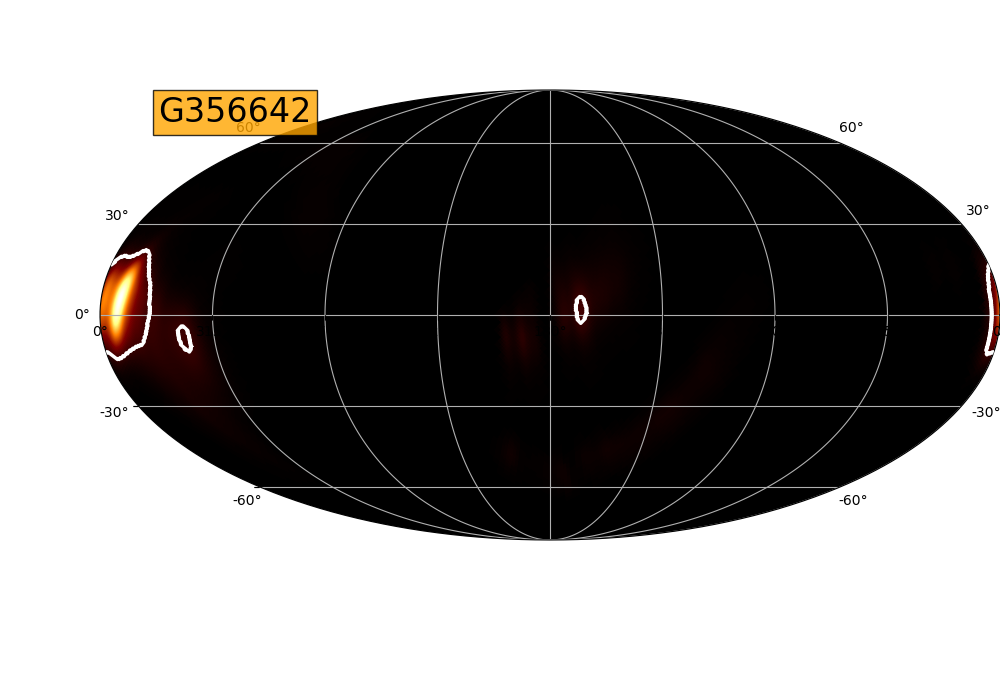

In [68]:
astro.show_contours_from_gw_bayestar(super_event_name+'_bayestar.fits.gz', contours=contours,
                                     cmap='afmhot', contours_color='white', show_figure=True, 
                                     save_figure=super_event_name+'.pdf')

## Query the ESO Archive to collect data withing the contours

Now it is time to run the proper query to the Archive to obtain all data located within the contour regions. To do this you have two options:
* [Archive Science Portal](http://archive.eso.org/scienceportal/home)
* [Programmatic access](http://archive.eso.org/programmatic/)

There is, however, one last step before doing this. You need to convert the contours into polygons. This is done with:
```python
archive_observations.contours_to_polygons(contours, max_vertices=30)
```
where `max_vertices` is set to avoid crashes due to polygons with too many vertices in the queries.

In [77]:
polygons = polygons.contours_to_polygons(contours, max_vertices=30)

The resulting `polygons` is a list with N elements (with N matching the number of contours). Each elements contains a string defining the location in the sky of the polygon with RA, Dec, seprated by commas and with the first RA, Dec pair that matches the last one (to close the polygon). For instance:

In [78]:
polygons[1]

'167.8711, -2.5374, 166.9922, -2.0894, 166.1133, -1.3430, 165.9375, -0.5968, 165.7617, 0.1492, 165.5859, 0.8953, 165.4102, 1.6415, 165.2344, 2.3880, 165.7617, 3.1349, 166.2891, 3.8824, 166.4648, 4.6305, 166.6406, 5.3794, 167.5195, 5.8292, 168.3984, 5.6792, 169.2773, 4.9300, 169.4531, 4.1815, 169.6289, 3.4338, 169.8047, 2.6867, 169.6289, 1.9401, 169.4531, 1.1938, 169.2773, 0.4476, 169.1016, -0.2984, 168.9258, -1.0445, 168.7500, -1.7908, 167.8711, -2.5374'

### Archive Science Portal Query:
After running:
```python
archive_observations.query_ASP_from_polygons(polygons=polygons, open_link=True)
```
you should see different ASP pages opening in your broswer (one per polygon) pointing to the different regions of the sky you are quering.

In [79]:
archive_science_portal.query_from_polygons(polygons=polygons, open_link=True)

### Programmatic access:
```python
archive_observations.query_TAP_from_polygons(polygons=polygons)
```
returns the result of the query:
```SQL
SELECT
   target_name, dp_id, s_ra, s_dec, t_exptime, em_min, em_max, 
   dataproduct_type, instrument_name, abmaglim, proposal_id
FROM
   ivoa.ObsCore
WHERE
   intersects(s_region, POLYGON('', `polygon`)) = 1
```
for convenince `maxrec` is set to `2` so only the first two results are returned, but you may want to increase this value.

In [85]:
result_from_query = archive_observations.query_from_polygons(polygons=polygons, maxrec=2, verbose=False)

[WORKING] :: Running query 1 to the ESO archive (out of 3 total)
[INFO]    :: A total of 2 entries has been retrieved
[WORKING] :: Running query 2 to the ESO archive (out of 3 total)
[INFO]    :: A total of 2 entries has been retrieved
[WORKING] :: Running query 3 to the ESO archive (out of 3 total)
[INFO]    :: A total of 2 entries has been retrieved


now you can download the data by exploring the `dp_id` of the results: 

In [86]:
archive_observations.download(result_from_query[0]['dp_id'])

[INFO]    :: Your disk has: Total: 397.03 GB, Used: 397.03 GB, Free: 397.03 GB
[WORKING] :: Retrieving file ADP.2016-07-29T07:24:35.237.fits
[INFO]    :: File ADP.2016-07-29T07:24:35.237.fits downloaded
[WORKING] :: Retrieving file ADP.2016-07-29T07:24:35.241.fits
[INFO]    :: File ADP.2016-07-29T07:24:35.241.fits downloaded


## All in one
The same resuls are achievable with the (un-official) ESOAsg script:
```python
get_data_from_gw_event.py
```